Import required packages

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy import distance
import folium
import requests
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Import Foursquare credentials from json file created to preserve secrecy and store in global variables CLIENT_ID and CLIENT_SECRET

In [2]:
import json
globals().update(json.loads(open("foursquareCredentials.json", "r") .read()))
VERSION = '20181124' # Foursquare API version

Get longitude and latitude of location

In [3]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("Rumbach Sebestyén u., Budapest, 1075 Hungary")
#location = geolocator.geocode("Galley Ave, Toronto")
lat = location.latitude
long = location.longitude

In [4]:
categoryId = '4bf58dd8d48988d16d941735' # Café
radius = 2
tick = 0.2

Define function degreeLen which for a given lat and long returns the length of a degree of lat and long in km

In [5]:
def degreeLen(lat, long):
    """Returns the lengths of a single degree of latitude and longitude in km for a given latitude and longitude
    """
    # get length of 1 degree at current latidude and logitude
    latDegree = distance.distance((lat - 0.5, long), (lat + 0.5, long)).km
    longDegree = distance.distance((lat, long - 0.5), (lat, long + 0.5)).km
    return latDegree, longDegree
degreeLen(lat, long)

(111.18052869040775, 75.34729533841742)

Define function grid that returns the set of grid points within a circle around location.  Grid points are a distance tick apart.

In [6]:
def grid(lat, long, radius, tick):
    """Returns a set whose elements are a grid of points within a circle around a location
    :param lat: latitude of centre of grid
    :param long: longitude of centre of grid
    :param radius: radius of grid in km
    :param tick: distance between points in grid in km
    """
    # get length of 1 degree at current latidude and logitude
    latDegree, longDegree = degreeLen(lat, long)
    
    # get length of 1 tick in degrees
    latTick = tick / latDegree
    longTick = tick / longDegree
    
    # get coordinates of point which is one radius to the South and West of (lat, long)
    bottomLeft = (lat - radius / latDegree, long - radius / longDegree)
    
    # get tick points along axis
    gridLats = np.arange(2 * radius / tick + 1) * latTick + bottomLeft[0]
    gridLongs = np.arange(2 * radius / tick + 1) * longTick + bottomLeft[1]
    
    # initialise set grid
    grid = set()
    
    # populate set grid
    for lt in gridLats:
        [grid.add((lt, lg)) for lg in gridLongs if distance.distance((lat, long), (lt, lg)).km <= radius]
        
    return grid

Check grid function is working using Folium

In [7]:
g = grid(lat, long, radius, tick)
# create map
map_grid = folium.Map(location=[lat, long], zoom_start=13)

for (lt, lg) in g:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=0.5).add_to(map_grid)
       
map_grid

In [8]:
len(g)

310

Define function for pulling list of nearby venues, with optional filter on category Id

In [9]:
def getNearbyVenues(lat, long, radius, categoryId = ''):
    url = ('https://api.foursquare.com/v2/venues/search?' +
            '&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION) +
            '&intent=browse&ll={},{}&radius={}&categoryId={}'.format(lat, long, radius, categoryId))
    
    venues = requests.get(url).json()['response']['venues']
    venues_list=[]
    
    for v in venues:
        if len(v['categories']) > 0:
            venues_list.append([v['id'], v['name'], v['location']['distance'], v['categories'][0]['name']])
        else:
            venues_list.append([v['id'], v['name'], v['location']['distance'], 'None'])
    
    return(venues_list)

Check function getNearbyVenues is working

In [11]:
getNearbyVenues(lat, long, tick * 1000, categoryId)

[['510c25ede4b0a3ee4308e94a', 'Központ', 188, 'Café'],
 ['4c9ce18c542b224bbaade49f', 'Drum Cafe', 100, 'Café'],
 ['52054dd511d2778ebd4f1cf3', 'Blue Bird Cafe', 171, 'Café'],
 ['514d9e95e4b01bb2769654a3', 'Solinfo', 67, 'Café'],
 ['5b9a6c1d1ffe97002c3349c7', 'Fresh Corner Downtown', 187, 'Café'],
 ['4c8e63f5a8de224be0182701', 'Café Vian', 182, 'French Restaurant'],
 ['54535798498ef0cd9c592e6e', 'Blue Bird Roastery', 137, 'Café'],
 ['4b804281f964a520d36130e3', 'Spinoza Café', 87, 'Restaurant'],
 ['4b99441cf964a520be6e35e3', 'Printa Café', 111, 'Art Gallery'],
 ['5152e6f0e4b02b6799b2ef78', 'Tom Dixon Cafè & Showroom', 62, 'Café'],
 ['57c41471498e814e459823ff', 'Blue Bird Cafe', 130, 'Café'],
 ['5bda0a2bb3c961002badd1c6', 'Kárpit Café', 128, 'Café'],
 ['582332825c3b582b1122a742', 'Cabbage Coffee', 147, 'Café'],
 ['4c20cfe93573c9b602ea3515', 'Café Zenit', 148, 'Pub'],
 ['4e5e5c65a809fd79d2976f26', 'Bench Café', 159, 'Café'],
 ['4d78b13e9e57a0932180c72b',
  "Osteria dell' Oca Italian Restaur

Define function targetDensity which outputs a measure the density of a list of venues within a specific radius of a location.
The density measure has the property of being larger the more venues there are in the list and the closer they are.
So for each venue we subtract the distance from the radius so that a venue in the centre of the circle adds the radius distance to the density measure while a venue on the edge of the circle adds 0 to the density measure.

In [12]:
def targetDensity(venues, radius):
    distances = []
    [distances.append(radius/(v[2] + 1)) for v in venues if v[2] <= radius]
    return np.sum(np.asarray(distances))

In [13]:
targetDensity(getNearbyVenues(lat, long, tick * 1000, categoryId), tick * 1000)

40.441510290053685

In [14]:
# Check if density for empty list of venues = 0
targetDensity([], tick * 1000)

0.0

In [15]:
targets = []
ids = set()
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, tick * 1000, categoryId)
    density = targetDensity(venues, tick * 1000)
    targets.append((lt, lg, density))
    for (v_id, name, distance, category) in venues:
        ids.add(v_id)

(47.498829676137355, 19.078470527130836)
(47.50422630454943, 19.062544275304408)
(47.49343304772528, 19.03600052226036)
(47.4970308, 19.067853025913216)
(47.50242742841207, 19.03865489756476)
(47.50242742841207, 19.065198650608814)
(47.491634171587926, 19.041309272869167)
(47.4970308, 19.057235524695596)
(47.4970308, 19.083779277739648)
(47.506025180686784, 19.054581149391193)
(47.511421809098856, 19.070507401217622)
(47.50242742841207, 19.0598899)
(47.50782405682414, 19.043963648173573)
(47.51322068523621, 19.065198650608814)
(47.48983529545056, 19.083779277739648)
(47.498829676137355, 19.04927239878238)
(47.50782405682414, 19.04661802347798)
(47.51322068523621, 19.062544275304408)
(47.47904203862642, 19.0598899)
(47.491634171587926, 19.067853025913216)
(47.49343304772528, 19.03865489756476)
(47.49343304772528, 19.065198650608814)
(47.50242742841207, 19.03600052226036)
(47.506025180686784, 19.081124902435242)
(47.50782405682414, 19.051926774086787)
(47.49523192386264, 19.0705074012176

(47.50062855227471, 19.083779277739648)
(47.48443866703849, 19.051926774086787)
(47.491634171587926, 19.073161776522028)
(47.4970308, 19.043963648173573)
(47.50422630454943, 19.03600052226036)
(47.506025180686784, 19.0598899)
(47.50782405682414, 19.073161776522028)
(47.488036419313204, 19.041309272869167)
(47.49523192386264, 19.04927239878238)
(47.50062855227471, 19.078470527130836)
(47.5096229329615, 19.062544275304408)
(47.511421809098856, 19.04661802347798)
(47.48263979090113, 19.0598899)
(47.488036419313204, 19.07581615182643)
(47.49523192386264, 19.067853025913216)
(47.498829676137355, 19.03600052226036)
(47.50422630454943, 19.051926774086787)
(47.48443866703849, 19.078470527130836)
(47.48983529545056, 19.04927239878238)
(47.498829676137355, 19.057235524695596)
(47.498829676137355, 19.083779277739648)
(47.50422630454943, 19.054581149391193)
(47.51322068523621, 19.070507401217622)
(47.48983529545056, 19.065198650608814)
(47.48983529545056, 19.03865489756476)
(47.49523192386264, 19.

In [16]:
targetsDf = pd.DataFrame(targets)
targetsDf.columns = ['Latitude', 'Longitude', 'Density']
targetsDf.set_index(['Latitude', 'Longitude'], inplace=True)
targetsDf.sort_index(inplace=True)
targetsDf

Density
Latitude  Longitude           
47.479042 19.059890   0.000000
47.480841 19.049272   2.333968
          19.051927  19.057103
          19.054581  12.860103
          19.057236   1.369863
          19.059890   0.000000
          19.062544   0.000000
          19.065199   9.708168
          19.067853   8.959340
          19.070507  29.951250
47.482640 19.046618   0.000000
          19.049272   0.000000
          19.051927  16.358094
          19.054581  25.282808
          19.057236   1.104972
          19.059890   3.729311
          19.062544   1.136364
          19.065199   3.643755
          19.067853   9.428642
          19.070507  21.193876
          19.073162  14.357979
47.484439 19.041309   0.000000
          19.043964   0.000000
          19.046618   0.000000
          19.049272   0.000000
          19.051927   2.523465
          19.054581   3.517090
          19.057236   0.000000
          19.059890  28.519116
          19.062544  18.927819
...                        ...
47.509623 19.059890   6.485854
          19.062544   7.964306
          19.065199   6.245214
          19.067853  12.427188
          19.070507   5.398856
          19.073162   1.123596
          19.075816   0.000000
          19.078471   2.298701
47.511422 19.043964   0.000000
          19.046618   7.800030
          19.049272  11.090996
          19.051927  33.351767
          19.054581  13.243443
          19.057236  38.690623
          19.059890  14.699434
          19.062544   9.212915
          19.065199   4.611401
          19.067853   5.434004
          19.070507   2.974138
          19.073162   5.976431
          19.075816   2.152093
47.513221 19.049272  19.864054
          19.051927  15.210284
          19.054581  11.104718
          19.057236  60.100192
          19.059890  53.338711
          19.062544   1.234568
          19.065199   0.000000
          19.067853   0.000000
          19.070507   1.041667

[310 rows x 1 columns]

In [17]:
targetsDf.describe()

,Density
count,310.000000
mean,12.421769
std,13.243957
min,0.000000
25%,2.162186
50%,7.889733
75%,19.043481
max,60.100192


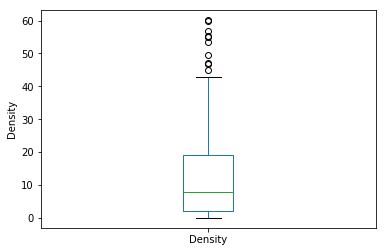

In [18]:
targetsDf.plot(y='Density', kind='box')
plt.ylabel('Density')
plt.show()

In [19]:
targetsDf['Density Log'] = np.log10(targetsDf['Density'].values + 1)

In [20]:
targetsDf.describe()

,Density,Density Log
count,310.000000,310.000000
mean,12.421769,0.881717
std,13.243957,0.506863
min,0.000000,0.000000
25%,2.162186,0.499987
50%,7.889733,0.948873
75%,19.043481,1.301973
max,60.100192,1.786043


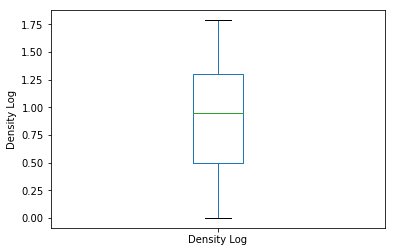

In [21]:
targetsDf.plot(y='Density Log', kind='box')
plt.ylabel('Density Log')
plt.show()

In [22]:
ids

{'4b405e24f964a520e1b725e3',
 '4b45eee3f964a520821226e3',
 '4b4fb933f964a520a41227e3',
 '4b52bdaef964a520328727e3',
 '4b559b58f964a520d2e827e3',
 '4b561c01f964a520d00028e3',
 '4b66f242f964a520a7312be3',
 '4b68a5d2f964a520be842be3',
 '4b69bf00f964a52085b12be3',
 '4b69c896f964a520f8b32be3',
 '4b6af49df964a520cae82be3',
 '4b76ff93f964a520e7722ee3',
 '4b782fcbf964a520b8ba2ee3',
 '4b7e8a1af964a520bcf12fe3',
 '4b7f05e8f964a520051130e3',
 '4b804281f964a520d36130e3',
 '4b82aa9af964a52052dd30e3',
 '4b83b33cf964a520670d31e3',
 '4b85b1e3f964a5205f6d31e3',
 '4b99441cf964a520be6e35e3',
 '4b9b6c79f964a520730636e3',
 '4b9fa2e8f964a520803037e3',
 '4ba15a89f964a5206baf37e3',
 '4ba1e53ff964a520efd037e3',
 '4ba4b1b7f964a520e0ac38e3',
 '4ba644eaf964a520ec4039e3',
 '4ba74045f964a520f38739e3',
 '4bab8db2f964a5200ab33ae3',
 '4bb2507d14cfd13a47c514ab',
 '4bb354612397b713b1f137b3',
 '4bb4d546bc82a593ade83e72',
 '4bbadceeb35776b08763cb01',
 '4bbf46e898f49521ef56d263',
 '4bbf610a006dc9b6377afc3f',
 '4bbf8d8aabf4

In [23]:
otherVenues = []
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, tick * 1000)
    for (v_id, name, distance, category) in venues:
        if not (v_id in ids) and category != 'None':
            otherVenues.append((lt, lg, v_id, name, distance, category))

(47.498829676137355, 19.078470527130836)
(47.50422630454943, 19.062544275304408)
(47.49343304772528, 19.03600052226036)
(47.4970308, 19.067853025913216)
(47.50242742841207, 19.03865489756476)
(47.50242742841207, 19.065198650608814)
(47.491634171587926, 19.041309272869167)
(47.4970308, 19.057235524695596)
(47.4970308, 19.083779277739648)
(47.506025180686784, 19.054581149391193)
(47.511421809098856, 19.070507401217622)
(47.50242742841207, 19.0598899)
(47.50782405682414, 19.043963648173573)
(47.51322068523621, 19.065198650608814)
(47.48983529545056, 19.083779277739648)
(47.498829676137355, 19.04927239878238)
(47.50782405682414, 19.04661802347798)
(47.51322068523621, 19.062544275304408)
(47.47904203862642, 19.0598899)
(47.491634171587926, 19.067853025913216)
(47.49343304772528, 19.03865489756476)
(47.49343304772528, 19.065198650608814)
(47.50242742841207, 19.03600052226036)
(47.506025180686784, 19.081124902435242)
(47.50782405682414, 19.051926774086787)
(47.49523192386264, 19.0705074012176

(47.50062855227471, 19.083779277739648)
(47.48443866703849, 19.051926774086787)
(47.491634171587926, 19.073161776522028)
(47.4970308, 19.043963648173573)
(47.50422630454943, 19.03600052226036)
(47.506025180686784, 19.0598899)
(47.50782405682414, 19.073161776522028)
(47.488036419313204, 19.041309272869167)
(47.49523192386264, 19.04927239878238)
(47.50062855227471, 19.078470527130836)
(47.5096229329615, 19.062544275304408)
(47.511421809098856, 19.04661802347798)
(47.48263979090113, 19.0598899)
(47.488036419313204, 19.07581615182643)
(47.49523192386264, 19.067853025913216)
(47.498829676137355, 19.03600052226036)
(47.50422630454943, 19.051926774086787)
(47.48443866703849, 19.078470527130836)
(47.48983529545056, 19.04927239878238)
(47.498829676137355, 19.057235524695596)
(47.498829676137355, 19.083779277739648)
(47.50422630454943, 19.054581149391193)
(47.51322068523621, 19.070507401217622)
(47.48983529545056, 19.065198650608814)
(47.48983529545056, 19.03865489756476)
(47.49523192386264, 19.

In [24]:
otherVenuesDf = pd.DataFrame(otherVenues)
otherVenuesDf.columns = ['Latitude', 'Longitude', 'VenueID', 'Name', 'Distance', 'Category']
otherVenuesDf.set_index(['Latitude', 'Longitude'], inplace=True)
otherVenuesDf.sort_index(inplace=True)
otherVenuesDf

VenueID  \
Latitude  Longitude                             
47.479042 19.059890  4ba3b92bf964a5206c5838e3   
          19.059890  4ba8e306f964a5202cf739e3   
          19.059890  4f059727d3e321b78f7a6655   
          19.059890  5669bf30498e50a39729c6de   
          19.059890  511a3517e4b0d096c320ede9   
          19.059890  4e08adaaa809495e61a017a8   
          19.059890  4d09d878ddb8f04dfb9e30aa   
          19.059890  526513c8498e22282fd037a2   
          19.059890  4ea694f07ee5bebc94b27a20   
          19.059890  4fcef568e4b0b4dd488d5295   
          19.059890  4e4976c31fc7a73d0db38fcd   
          19.059890  5240014f11d29e0419c1077b   
          19.059890  4ba8e9eff964a52097f939e3   
          19.059890  582ed5e00b5656378a87d099   
          19.059890  52fcbf52498e5a3089ed1df9   
          19.059890  4ba8ebeaf964a52058fa39e3   
          19.059890  51b86e3e498e2a70c2f4930e   
          19.059890  507575ebe4b01d2c3d4b03a3   
          19.059890  5139e6afe4b0257b60e03cda   
          19.059890  508bf7b1e4b0a1c8476fff2d   
          19.059890  506182fae4b008c57d902a7c   
          19.059890  4f44c1c8e4b0f1d45d1efbcb   
          19.059890  576ce61c498e72c8c4d7935e   
          19.059890  5703ab49498e54b9c6689c1f   
          19.059890  58739e2f45c3ed099825fd76   
          19.059890  551cea77498e7ada62c89a0b   
          19.059890  545b5c76498ee6fdb442ad29   
          19.059890  4ca8fb87965c9c74a1eac9fa   
          19.059890  5bed8e5ff1fdaf002c2ad53d   
          19.059890  4f38e491e4b0d408a5eda9e2   
...                                       ...   
47.513221 19.070507  4d2daf8baa5c6ea8cd39af04   
          19.070507  4c8a42021eafb1f7d6787835   
          19.070507  56b8eaac498e84344c13e44f   
          19.070507  4f8d8f77e4b07efba19ac369   
          19.070507  56dc5c4d498e9bfed83e5a9a   
          19.070507  593d1b82088158548cf02b4f   
          19.070507  59d4bf8a67af3a1571dbab7d   
          19.070507  4ea04dca722e575b9ed40d86   
          19.070507  5b7562651953f3002c045a98   
          19.070507  4e6a1d83922ec475e8907c12   
          19.070507  564f4887498e9cd06b7e9ad6   
          19.070507  53442630498eb143ea755472   
          19.070507  4ce02f7570bba1cd98e06ac4   
          19.070507  4e6efb1f8998fd5c566ace68   
          19.070507  4e8eb3c9b8f7c08295aa22b8   
          19.070507  5898a0cf1e1de501d968c097   
          19.070507  53b80580498e041871fa8844   
          19.070507  4eb39d5293ad23656f5c6875   
          19.070507  4d7b5eb4645ea35d55b930f8   
          19.070507  4f9cfaf2e4b060916940d353   
          19.070507  519e3ce4498ec1672c4049dc   
          19.070507  4e9717dd93ad7ae7cd49e22d   
          19.070507  59b6e8493c858d7f3bf6f83f   
          19.070507  5103aed1e4b0a3acd2913f29   
          19.070507  4e68976462e1a02a61143102   
          19.070507  536620ec498e7186ef609364   
          19.070507  590845f29e0d541198c42483   
          19.070507  4ec22fc7b8f7963bcec4f840   
          19.070507  4d090fc184ec224b7cfd2c62   
          19.070507  4fa7cc05e4b0baf7cefb2e18   

                                                                  Name  \
Latitude  Longitude                                                      
47.479042 19.059890                                         Petőfi híd   
          19.059890                                       BME R épület   
          19.059890                    BME Központi Tanulmányi Hivatal   
          19.059890                   Műegyetemi Református Lelkészség   
          19.059890                                            BME R4D   
          19.059890                   Valdemar és Nina Langlet rakpart   
          19.059890                    BME Nukleáris Technikai Intézet   
          19.059890                   Hardbodyhang Street Workout Park   
          19.059890                   BME Hallgatói Számítógép Központ   
          19.059890                                           BME R108   
          19.059890                                   BME Spor

In [25]:
otherVenuesDf['Density'] = (tick * 1000)/(otherVenuesDf['Distance'].values + 1) 

In [26]:
otherVenuesDf.groupby(['Latitude', 'Longitude', 'Category'])['Density'].sum().to_frame()

Density
Latitude  Longitude Category                                           
47.479042 19.059890 Athletics & Sports                         1.428571
                    Bank                                       1.047120
                    Bridge                                     0.840336
                    Buffet                                     3.773585
                    College Academic Building                  6.515440
                    College Administrative Building            5.405405
                    College Arts Building                      0.975610
                    College Classroom                         15.295009
                    College Lab                                6.193210
                    College Science Building                   7.125890
                    Doctor's Office                            1.470588
                    Garden                                     1.092896
                    Gym / Fitness Center                       1.117318
                    Prayer Room                                7.407407
                    Road                                       9.090909
                    Squash Court                               0.961538
                    Student Center                            10.714286
                    University                                 1.149425
47.480841 19.049272 Arcade                                     4.651163
                    Art Gallery                                1.204819
                    Athletics & Sports                         2.564103
                    Bar                                        1.204819
                    Basketball Court                           6.388330
                    Beer Garden                                1.315789
                    Bike Shop                                  2.857143
                    Bookstore                                  2.020202
                    College Auditorium                         3.333333
                    College Cafeteria                         12.422635
                    College Gym                                3.030303
                    College Library                            4.444444
...                                                                 ...
47.513221 19.067853 Smoke Shop                                 7.145136
                    Spiritual Center                           0.443459
                    Tailor Shop                                3.389831
                    Thrift / Vintage Store                     4.081633
          19.070507 Art Gallery                                3.076923
                    Auditorium                                 5.405405
                    Beer Garden                                2.272727
                    Betting Shop                               2.898551
                    Church                                     1.694915
                    College Arts Building                      5.070603
                    Convenience Store                          2.409639
                    Deli / Bodega                              1.562500
                    Department Store                           3.076923
                    Flower Shop                                1.754386
                    Garden                                     2.816901
                    Gay Bar                                    1.142857
                    Grocery Store                              1.680672
                    Gym / Fitness Center                       0.140351
                    Liquor Store                               2.247191
                    Office                                     7.347569
                    Pastry Shop                                2.127660
                    Perfume Shop                               1.904762
                    Pool                                       1.069519
                    Professional

In [27]:
features = pd.pivot_table(otherVenuesDf,index=['Latitude', 'Longitude'],values='Density',
                          columns='Category',aggfunc=[np.sum],fill_value=0)['sum']

In [28]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 310 entries, (47.47904203862642, 19.0598899) to (47.51322068523621, 19.070507401217622)
Columns: 495 entries, ATM to Zoo Exhibit
dtypes: float64(488), int64(7)
memory usage: 1.2 MB


In [29]:
features

Category             ATM  Accessories Store  Adult Boutique  \
Latitude  Longitude                                           
47.479042 19.059890  0.0           0.000000        0.000000   
47.480841 19.049272  0.0           0.000000        0.000000   
          19.051927  0.0           0.000000        0.000000   
          19.054581  0.0           0.000000        0.000000   
          19.057236  0.0           0.000000        0.000000   
          19.059890  0.0           0.000000        0.000000   
          19.062544  0.0           0.000000        0.000000   
          19.065199  0.0           0.000000        0.000000   
          19.067853  0.0           0.000000        0.000000   
          19.070507  0.0           0.000000        0.000000   
47.482640 19.046618  0.0           0.000000        0.000000   
          19.049272  0.0           0.000000        0.000000   
          19.051927  0.0           0.000000        0.000000   
          19.054581  0.0           0.000000        0.000000   
          19.057236  0.0           0.000000        0.000000   
          19.059890  0.0           0.000000        0.000000   
          19.062544  0.0           0.000000        0.000000   
          19.065199  0.0           0.000000        0.000000   
          19.067853  0.0           0.000000        2.898551   
          19.070507  0.0           0.000000        0.000000   
          19.073162  0.0           0.000000        0.000000   
47.484439 19.041309  0.0           0.000000        0.000000   
          19.043964  0.0           0.000000        0.000000   
          19.046618  0.0           0.000000        0.000000   
          19.049272  0.0           0.000000        0.000000   
          19.051927  0.0           0.000000        0.000000   
          19.054581  0.0           0.000000        0.000000   
          19.057236  0.0           0.000000        0.000000   
          19.059890  0.0           0.000000        0.000000   
          19.062544  0.0           0.000000        0.000000   
...                  ...                ...             ...   
47.509623 19.059890  0.0           0.000000        0.000000   
          19.062544  0.0           0.000000        0.000000   
          19.065199  0.0           7.692308        0.000000   
          19.067853  0.0           0.000000        0.000000   
          19.070507  0.0           0.000000        0.000000   
          19.073162  0.0           0.000000        0.000000   
          19.075816  0.0           0.000000        0.000000   
          19.078471  0.0           0.000000        0.000000   
47.511422 19.043964  0.0           0.000000        0.000000   
          19.046618  0.0           0.000000        0.000000   
          19.049272  0.0           0.000000        0.000000   
          19.051927  0.0           0.000000        0.000000   
          19.054581  0.0           0.000000        0.000000   
          19.057236  0.0           0.000000        0.000000   
          19.059890  0.0           0.000000        0.000000   
          19.062544  0.0           0.000000        0.000000   
          19.065199  0.0           0.000000        0.000000   
          19.067853  0.0           0.000000        0.000000   
          19.070507  0.0           0.000000        0.000000   
          19.073162  0.0           0.000000        0.000000   
          19.075816  0.0           0.000000        0.000000   
47.513221 19.049272  0.0           0.000000        0.000000   
          19.051927  0.0           0.000000        0.000000   
          19.054581  0.0           0.000000        0.000000   
          19.057236  0.0           0.000000        0.000000   
          19.059890  0.0           0.000000        0.000000   
          19.062544  0.0           0.000000        0.000000   
          19.065199  0.0           0.000000        0.000000   
          19.067853  0.0           0.000000        0.000000   
          19.070507  0.0           0.000000        0.000000   

Category             Advertisi

In [30]:
features.describe()

Category,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Waterfall,Waterfront,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,0.010995,0.175446,0.062808,0.214844,0.042339,0.048359,0.032459,0.008489,0.026799,0.132236,...,0.016224,0.030674,0.007612,0.040986,0.543873,0.102635,0.087509,0.423610,0.438403,0.008890
std,0.137616,1.096736,0.627468,1.417135,0.594500,0.592506,0.344184,0.149464,0.366732,0.884294,...,0.237820,0.217275,0.095036,0.305282,1.669830,0.685238,0.502099,2.335049,1.871711,0.112101
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.904762,11.764706,9.090909,16.273585,10.000000,10.000000,5.405405,2.631579,6.060606,8.333333,...,4.081633,2.150538,1.290323,2.941176,15.384615,7.407407,4.878049,25.000000,20.000000,1.612903


In [31]:
features = np.log10(features + 1)

In [32]:
features.describe()

Category,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Waterfall,Waterfront,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,0.002780,0.024690,0.009379,0.027394,0.005345,0.007392,0.006490,0.001807,0.004388,0.020647,...,0.003211,0.008178,0.002180,0.009383,0.092990,0.017820,0.018669,0.044545,0.066131,0.002413
std,0.034648,0.139874,0.084871,0.149459,0.068606,0.072204,0.060603,0.031811,0.056207,0.121358,...,0.043291,0.055720,0.027153,0.068029,0.230897,0.108429,0.098579,0.202649,0.208778,0.030196
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.463111,1.106011,1.003930,1.237382,1.041393,1.041393,0.806547,0.560095,0.848842,0.970037,...,0.706003,0.498385,0.359897,0.595626,1.214436,0.924662,0.769233,1.414973,1.322219,0.417123


In [33]:
features = features.join(targetsDf).fillna(0).reset_index()

In [34]:
features.describe()

,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit,Density,Density Log
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,47.497135,19.059890,0.002780,0.024690,0.009379,0.027394,0.005345,0.007392,0.006490,0.001807,...,0.002180,0.009383,0.092990,0.017820,0.018669,0.044545,0.066131,0.002413,12.421769,0.881717
std,0.008983,0.013169,0.034648,0.139874,0.084871,0.149459,0.068606,0.072204,0.060603,0.031811,...,0.027153,0.068029,0.230897,0.108429,0.098579,0.202649,0.208778,0.030196,13.243957,0.506863
min,47.479042,19.036001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.489835,19.049272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.162186,0.499987
50%,47.497031,19.059890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.889733,0.948873
75%,47.504226,19.070507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.043481,1.301973
max,47.513221,19.083779,0.463111,1.106011,1.003930,1.237382,1.041393,1.041393,0.806547,0.560095,...,0.359897,0.595626,1.214436,0.924662,0.769233,1.414973,1.322219,0.417123,60.100192,1.786043


In [35]:
X = features.drop(['Latitude', 'Longitude', 'Density', 'Density Log'], axis=1)
y = features['Density Log']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=22)

In [37]:
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train)
y_pred_test = reg_all.predict(X_test)
y_pred_train = reg_all.predict(X_train)
reg_all.score(X_test, y_test)

-0.4117192844314926

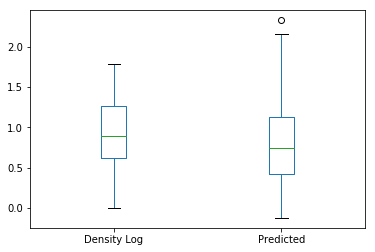

In [38]:
testDf = y_test.to_frame()
testDf['Predicted'] = y_pred_test
testDf.plot(kind='box')
plt.show()

In [39]:
testDf.describe()

,Density Log,Predicted
count,93.000000,93.000000
mean,0.884985,0.816658
std,0.470452,0.524922
min,0.000000,-0.121462
25%,0.621274,0.417242
50%,0.889636,0.750820
75%,1.262137,1.129707
max,1.783398,2.329789


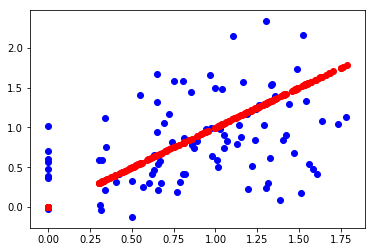

In [40]:
plt.scatter(y_test, y_pred_test, color='blue')
plt.scatter(y_train, y_pred_train, color='red')
plt.show()

In [41]:
lasso = linear_model.Lasso(alpha=0.005, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred_test = lasso.predict(X_test)
lasso_pred_train = lasso.predict(X_train)
lasso.score(X_test, y_test)

0.25027266544608595

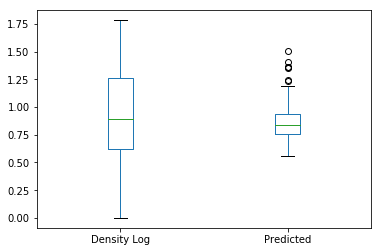

In [42]:
testDf = y_test.to_frame()
testDf['Predicted'] = lasso_pred_test
testDf.plot(kind='box')
plt.show()

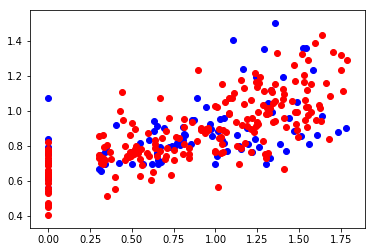

In [43]:
plt.scatter(y_test, lasso_pred_test, color='blue')
plt.scatter(y_train, lasso_pred_train, color='red')
plt.show()

In [44]:
lasso_pred_all = lasso.predict(X)

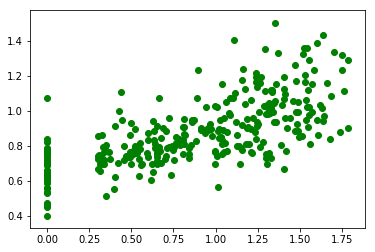

In [45]:
plt.scatter(y, lasso_pred_all, color='green')
plt.show()

In [46]:
len(lasso_pred_all)

310

In [47]:
results = features[['Latitude', 'Longitude', 'Density Log']]

In [48]:
results['Predicted'] = lasso_pred_all

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


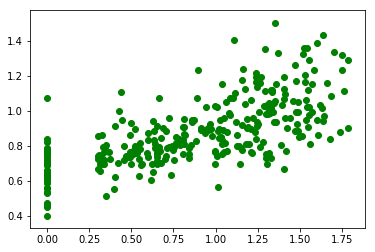

In [49]:
plt.scatter(results['Density Log'], results['Predicted'], color='green')
plt.show()

In [50]:
results['Rank'] = results['Predicted'] / (results['Density Log'] + 1)

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
top10 = results.sort_values(by='Rank', ascending=False).head(10)
top10

,Latitude,Longitude,Density Log,Predicted,Rank
50,47.486238,19.078471,0.000000,1.072153,1.072153
257,47.507824,19.041309,0.000000,0.837048,0.837048
308,47.513221,19.067853,0.000000,0.819305,0.819305
223,47.504226,19.043964,0.000000,0.789990,0.789990
141,47.495232,19.078471,0.000000,0.780799,0.780799
148,47.497031,19.046618,0.437613,1.109848,0.772008
10,47.482640,19.046618,0.000000,0.771591,0.771591
105,47.491634,19.083779,0.000000,0.761264,0.761264
222,47.504226,19.041309,0.000000,0.753923,0.753923
0,47.479042,19.059890,0.000000,0.744900,0.744900


In [52]:
l = list(zip(top10['Latitude'], top10['Longitude']))
l

[(47.48623754317585, 19.078470527130836),
 (47.50782405682414, 19.041309272869167),
 (47.51322068523621, 19.067853025913216),
 (47.50422630454943, 19.043963648173573),
 (47.49523192386264, 19.078470527130836),
 (47.4970308, 19.04661802347798),
 (47.48263979090113, 19.04661802347798),
 (47.491634171587926, 19.083779277739648),
 (47.50422630454943, 19.041309272869167),
 (47.47904203862642, 19.0598899)]

In [53]:
# create map
map_grid = folium.Map(location=[lat, long], zoom_start=13)

for (lt, lg) in l:
    folium.CircleMarker([lt, lg],
                        radius=4,
                        fill=True,
                        fill_opacity=0.5,
                        color='Red').add_to(map_grid)
       
map_grid